# Pythonチャレンジ: 地震データを探る

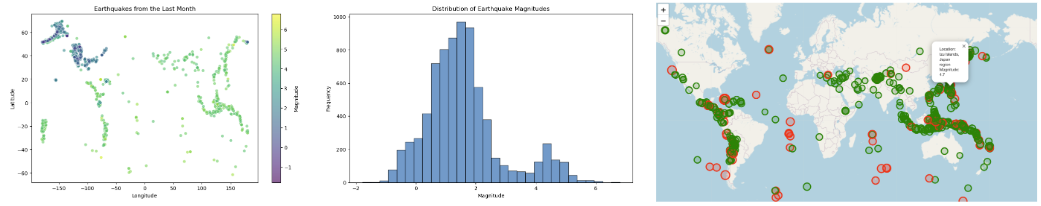

目的: Pythonを使ってUSGS（アメリカ地質調査所）のリアルタイム地震APIから最新の地震データを取得し、意味のある分析を行います。このチャレンジの最終目標は、世界中の地震を視覚化することです。

## 始めに

参考リンク：

- USGS 地震プログラム ホームページ: https://www.usgs.gov/programs/earthquake-hazards/earthquakes
- リアルタイムCSVデータ（スプレッドシート）API: https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php

データの取得: USGSのリアルタイム地震APIを使用して、最新の地震データを取得します。APIの基本URLは以下の通りです：

https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv

以下のPythonスクリプトを作成して：
- APIにリクエストを送信。
- csv形式のレスポンスを解析し、各地震の位置、マグニチュード、深さ、発生時刻などの情報を抽出します。

### リクエストコード例

In [17]:
%pip install pandas requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import requests

# USGSから過去1か月の地震データを取得
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
response = requests.get(url)

# データをファイルに保存
with open('earthquakes.csv', 'wb') as file:
    file.write(response.content)

# データをDataFrameに読み込む
data = pd.read_csv('earthquakes.csv')

# データの最初の5行を表示
data.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-11-12T05:55:51.790Z,38.835335,-122.813835,1.67,0.70,md,11.0,58.0,0.017220,0.01,...,2025-11-12T05:57:27.846Z,"8 km W of Cobb, CA",earthquake,0.31,0.86,0.090,11.0,automatic,nc,nc
1,2025-11-12T05:53:04.750Z,34.032000,-117.234667,16.66,2.10,ml,114.0,14.0,0.083430,0.18,...,2025-11-12T06:03:47.800Z,"3 km SE of Loma Linda, CA",earthquake,0.12,0.26,0.160,25.0,automatic,ci,ci
2,2025-11-12T05:47:03.110Z,33.023333,-116.297000,7.10,1.57,ml,67.0,29.0,0.068750,0.18,...,2025-11-12T05:57:42.840Z,"20 km SW of Ocotillo Wells, CA",earthquake,0.14,0.45,0.204,26.0,automatic,ci,ci
3,2025-11-12T05:44:38.900Z,38.784832,-122.772667,0.56,0.71,md,7.0,97.0,0.015090,0.04,...,2025-11-12T05:46:13.673Z,"2 km WNW of The Geysers, CA",earthquake,0.28,0.49,0.150,8.0,automatic,nc,nc
4,2025-11-12T05:43:10.640Z,38.817501,-122.792000,2.86,0.70,md,8.0,93.0,0.009802,0.01,...,2025-11-12T06:07:18.668Z,"5 km NW of The Geysers, CA",earthquake,0.46,0.97,0.260,8.0,automatic,nc,nc


## チャレンジ

**チャレンジ1: データの取得と表示**

APIから地震データを取得し、以下を表示：
- 過去1ヶ月に報告された地震の総数
- 最大マグニチュードの地震とその発生場所と日にち
- 日本での地震の数

In [19]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# === 1. USGSから過去1ヶ月の地震データを取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,  # M1.0以上に限定
    "limit": 20000  # 最大件数
}

response = requests.get(url, params=params)
data = response.json()

# === 2. データをDataFrame化 ===
features = data["features"]
records = []
for f in features:
    props = f["properties"]
    coords = f["geometry"]["coordinates"]
    records.append({
        "time": datetime.utcfromtimestamp(props["time"] / 1000),
        "place": props["place"],
        "magnitude": props["mag"],
        "longitude": coords[0],
        "latitude": coords[1]
    })

df = pd.DataFrame(records)

# === 3. 総数を表示 ===
total_quakes = len(df)
print(f"🌍 過去1ヶ月の地震の総数: {total_quakes} 件")

# === 4. 最大マグニチュードの地震 ===
max_quake = df.loc[df["magnitude"].idxmax()]
print(f"💥 最大マグニチュード: {max_quake['magnitude']}")
print(f"📍 発生場所: {max_quake['place']}")
print(f"🕒 発生日時(UTC): {max_quake['time']}")

# === 5. 日本付近の地震のみ抽出 ===
# 日本付近の緯度経度範囲でフィルタ（おおよそ）
japan_df = df[
    (df["latitude"].between(24, 46)) &
    (df["longitude"].between(122, 154))
].copy()

# 日ごとの地震数をカウント
japan_df["date"] = japan_df["time"].dt.date
daily_counts = japan_df.groupby("date").size()

print("\n📅 日本付近の地震発生数（日ごと）:")
print(daily_counts)

# === 6. 結果をCSVに保存したい場合 ===
# japan_df.to_csv("japan_earthquakes_last_month.csv", index=False)

C:\Users\shunk\AppData\Local\Temp\ipykernel_23592\2707493545.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


🌍 過去1ヶ月の地震の総数: 5112 件
💥 最大マグニチュード: 6.8
📍 発生場所: 126 km E of Yamada, Japan
🕒 発生日時(UTC): 2025-11-09 08:03:37.808000

📅 日本付近の地震発生数（日ごと）:
date
2025-10-13     2
2025-10-14     3
2025-10-15     2
2025-10-17     1
2025-10-18     3
2025-10-19     1
2025-10-20     1
2025-10-21     1
2025-10-22     1
2025-10-23     1
2025-10-24     5
2025-10-25     1
2025-10-26     2
2025-10-30     1
2025-11-01     1
2025-11-02     2
2025-11-03     2
2025-11-04     3
2025-11-05     2
2025-11-06     3
2025-11-07     2
2025-11-08    11
2025-11-09    29
2025-11-10    11
2025-11-11     1
dtype: int64


C:\Users\shunk\AppData\Local\Temp\ipykernel_23592\2707493545.py:28: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "time": datetime.utcfromtimestamp(props["time"] / 1000),


**チャレンジ2: 重要な地震のフィルタリング**

- マグニチュードが6.0を超える地震をフィルタリングし、`for` ループを使って以下をリストアップ：
    - その位置、マグニチュード、発生時刻
    - このような重要な地震の総数


In [20]:
import requests
from datetime import datetime, timedelta

# === 1. 過去1ヶ月の地震データをUSGSから取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,  # M1以上
    "limit": 20000
}

response = requests.get(url, params=params)
data = response.json()

# === 2. featuresから地震データを抽出 ===
features = data["features"]

# === 3. 重要な地震（M6.0超）をフィルタリング ===
important_quakes = []
for f in features:
    props = f["properties"]
    mag = props["mag"]
    place = props["place"]
    time = datetime.utcfromtimestamp(props["time"] / 1000)
    if mag and mag > 6.0:
        important_quakes.append({
            "place": place,
            "magnitude": mag,
            "time": time
        })

# === 4. 結果を表示 ===
print("🌋 マグニチュード6.0を超える地震（過去1ヶ月）:")
print("-" * 60)

for quake in important_quakes:
    print(f"📍 位置: {quake['place']}")
    print(f"💥 マグニチュード: {quake['magnitude']}")
    print(f"🕒 発生時刻(UTC): {quake['time']}")
    print("-" * 60)

print(f"🔢 重要な地震の総数: {len(important_quakes)} 件")


C:\Users\shunk\AppData\Local\Temp\ipykernel_23592\2299699479.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


🌋 マグニチュード6.0を超える地震（過去1ヶ月）:
------------------------------------------------------------
📍 位置: 121 km E of Yamada, Japan
💥 マグニチュード: 6.4
🕒 発生時刻(UTC): 2025-11-09 08:54:36.991000
------------------------------------------------------------
📍 位置: 126 km E of Yamada, Japan
💥 マグニチュード: 6.8
🕒 発生時刻(UTC): 2025-11-09 08:03:37.808000
------------------------------------------------------------
📍 位置: 155 km SE of Petropavlovsk-Kamchatsky, Russia
💥 マグニチュード: 6.1
🕒 発生時刻(UTC): 2025-11-03 08:44:43.471000
------------------------------------------------------------
📍 位置: 22 km WSW of Khulm, Afghanistan
💥 マグニチュード: 6.3
🕒 発生時刻(UTC): 2025-11-02 20:29:02.028000
------------------------------------------------------------
📍 位置: Banda Sea
💥 マグニチュード: 6.4
🕒 発生時刻(UTC): 2025-10-28 14:40:18.476000
------------------------------------------------------------
📍 位置: 162 km E of Beauséjour, Guadeloupe
💥 マグニチュード: 6.5
🕒 発生時刻(UTC): 2025-10-27 12:38:40.311000
------------------------------------------------------------
📍 位置:

C:\Users\shunk\AppData\Local\Temp\ipykernel_23592\2299699479.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  time = datetime.utcfromtimestamp(props["time"] / 1000)


**チャレンジ3: 地震の深さを分析**

- すべての地震の平均深度を計算してください。
- 地震を以下のカテゴリに分類し、それぞれの数を数えてください：
    - 浅い地震 (<70 km)
    - 中間深度地震 (70–300 km)
    - 深い地震 (>300 km)


In [21]:
import requests
from datetime import datetime, timedelta

# === 1. USGS API から過去30日のデータを取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,
    "limit": 20000
}

response = requests.get(url, params=params)
data = response.json()

# === 2. features から深さデータを抽出 ===
features = data["features"]

depths = []
for f in features:
    geom = f["geometry"]
    if geom and "coordinates" in geom:
        coords = geom["coordinates"]
        if len(coords) == 3:
            depth = coords[2]  # 深さは3番目の要素
            depths.append(depth)

# === 3. 平均深度の計算 ===
if len(depths) > 0:
    avg_depth = sum(depths) / len(depths)
else:
    avg_depth = 0

# === 4. 深さカテゴリごとにカウント ===
shallow = len([d for d in depths if d < 70])
intermediate = len([d for d in depths if 70 <= d <= 300])
deep = len([d for d in depths if d > 300])

# === 5. 結果を出力 ===
print("🌍 過去1ヶ月の地震深度分析 (USGS)")
print("-" * 50)
print(f"📊 平均深度: {avg_depth:.2f} km")
print(f"🟢 浅い地震 (<70km): {shallow} 件")
print(f"🟡 中間深度地震 (70–300km): {intermediate} 件")
print(f"🔵 深い地震 (>300km): {deep} 件")
print(f"📈 総地震数: {len(depths)} 件")


C:\Users\shunk\AppData\Local\Temp\ipykernel_23592\33301874.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


KeyboardInterrupt: 

**チャレンジ4: 時間分析**

- 地震のタイムスタンプ（ミリ秒単位のUNIX時間）を人間が読みやすい形式に変換して、日本時間として表示
- データセット内の最も早い地震と最新の地震の発生時刻を見つけてください。

In [ ]:
import requests
from datetime import datetime, timedelta, timezone

# === 1. USGS API から過去30日の地震データを取得 ===
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=30)

url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": start_time.strftime("%Y-%m-%d"),
    "endtime": end_time.strftime("%Y-%m-%d"),
    "minmagnitude": 1.0,
    "limit": 20000
}

response = requests.get(url, params=params)
data = response.json()

# === 2. JST（日本時間）用のタイムゾーンを定義 ===
JST = timezone(timedelta(hours=9))

# === 3. すべての地震の時刻をリスト化（UNIX ms → datetime JST） ===
times_jst = []
for f in data["features"]:
    t_ms = f["properties"]["time"]  # ミリ秒単位のUNIX時間
    t_jst = datetime.fromtimestamp(t_ms / 1000, tz=JST)
    times_jst.append(t_jst)

# === 4. 最も早い（古い）地震と最新の地震を特定 ===
if times_jst:
    earliest = min(times_jst)
    latest = max(times_jst)
else:
    earliest = latest = None

# === 5. 結果を表示 ===
print("🕒 USGS 地震データ 時間分析（過去1ヶ月）")
print("-" * 60)
print(f"📅 総地震数: {len(times_jst)} 件")
if earliest and latest:
    print(f"⏰ 最も早い地震（最古）: {earliest.strftime('%Y-%m-%d %H:%M:%S %Z')}")
    print(f"🕘 最新の地震: {latest.strftime('%Y-%m-%d %H:%M:%S %Z')}")
else:
    print("⚠️ データが取得できませんでした。")


C:\Users\shunk\AppData\Local\Temp\ipykernel_23592\206779130.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


🕒 USGS 地震データ 時間分析（過去1ヶ月）
------------------------------------------------------------
📅 総地震数: 5112 件
⏰ 最も早い地震（最古）: 2025-10-13 09:03:49 UTC+09:00
🕘 最新の地震: 2025-11-12 08:54:24 UTC+09:00


**チャレンジ5: 地震のマグニチュードを視覚化**

- 以下をプロットする棒グラフまたは散布図を作成してください：
    - x軸に地震のマグニチュード。
    - y軸に深さ。
    - 最大の地震と最も深い地震にラベルを追加。

In [ ]:
pip install requests matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


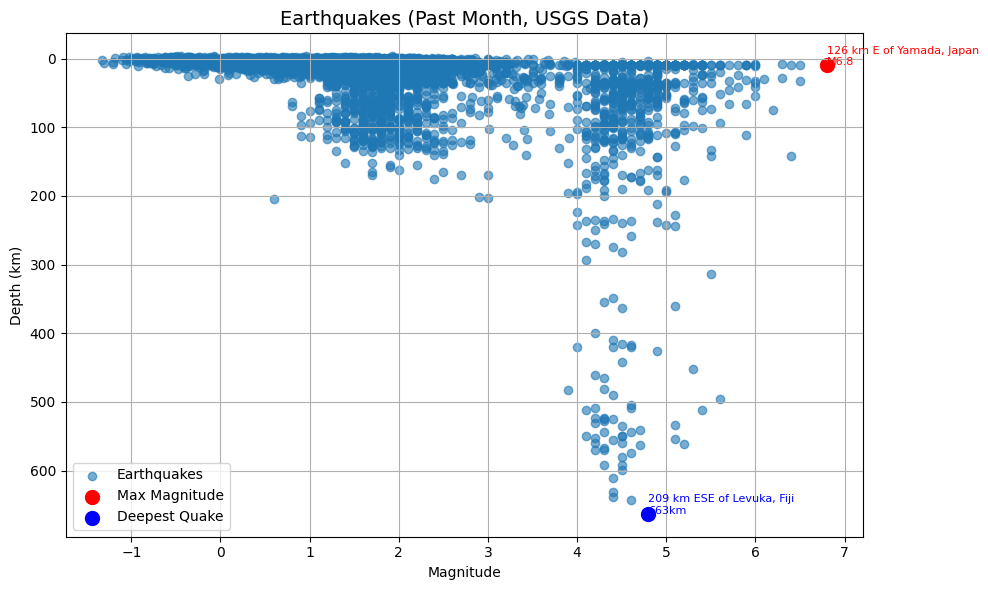

In [ ]:
import requests
import matplotlib.pyplot as plt

# === USGS から過去1ヶ月の地震データを取得 ===
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"
response = requests.get(url)
response.raise_for_status()
data = response.json()

features = data["features"]

# === データ抽出 ===
magnitudes = []
depths = []
locations = []

for quake in features:
    props = quake["properties"]
    geom = quake["geometry"]

    if props["mag"] is not None and geom and geom["coordinates"]:
        mag = props["mag"]
        depth = geom["coordinates"][2]  # 深さ（km）
        loc = props["place"] or "Unknown location"

        magnitudes.append(mag)
        depths.append(depth)
        locations.append(loc)

# === 最大マグニチュードと最大深度を特定 ===
max_mag = max(magnitudes)
max_depth = max(depths)

max_mag_index = magnitudes.index(max_mag)
max_depth_index = depths.index(max_depth)

max_mag_loc = locations[max_mag_index]
max_depth_loc = locations[max_depth_index]

# === 散布図を作成 ===
plt.figure(figsize=(10, 6))
plt.scatter(magnitudes, depths, alpha=0.6, label="Earthquakes")

# 最大マグニチュードの地震を赤で表示
plt.scatter(max_mag, depths[max_mag_index], color="red", s=100, label="Max Magnitude")
plt.text(max_mag, depths[max_mag_index], f"{max_mag_loc}\nM{max_mag:.1f}", fontsize=8, color="red")

# 最も深い地震を青で表示
plt.scatter(magnitudes[max_depth_index], max_depth, color="blue", s=100, label="Deepest Quake")
plt.text(magnitudes[max_depth_index], max_depth, f"{max_depth_loc}\n{max_depth:.0f}km", fontsize=8, color="blue")

# === 軸とタイトル ===
plt.title("Earthquakes (Past Month, USGS Data)", fontsize=14)
plt.xlabel("Magnitude")
plt.ylabel("Depth (km)")
plt.gca().invert_yaxis()  # 深い地震ほど下に
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**チャレンジ6（上級）: 地震のグローバルマップ作成**

- foliumまたはmatplotlibなどのマッピングライブラリを使用して、すべての地震を地図上にプロットしてください。
- 以下の特徴を追加してください：
    - 地震の位置をポイントで表示。
    - マグニチュードに基づいてポイントを色分け（例：<4.0は緑、4.0–6.0は黄色、>6.0は赤）。
    - ポイントにマウスを重ねると、地震の位置、マグニチュード、日本日付、深さを表示するツールチップを追加。

In [ ]:
pip install requests folium pytz


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# earthquake_map_folium.py
import requests
import folium
from folium import Tooltip
from datetime import datetime, timezone
import pytz

# --- ユーザー設定: ここを変えれば他のフィードにも切り替え可 ---
# 過去30日分（全ての地震）
USGS_GEOJSON_URL = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"
# 代替例: all_week.geojson, all_day.geojson, 2.5_week.geojson など
# --- /設定 ---

def mag_to_color(mag):
    try:
        if mag is None:
            return "gray"
        mag = float(mag)
        if mag < 4.0:
            return "green"
        elif mag <= 6.0:
            return "orange"  # 黄色系（folium標準色に合わせて orange）
        else:
            return "red"
    except:
        return "gray"

def fetch_usgs_geojson(url):
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    return r.json()

def utc_ms_to_jst_string(ms_since_epoch):
    # USGS の time は milliseconds since epoch (UTC)
    try:
        ts = int(ms_since_epoch) / 1000.0
        dt_utc = datetime.fromtimestamp(ts, tz=timezone.utc)
        jst = pytz.timezone("Asia/Tokyo")
        dt_jst = dt_utc.astimezone(jst)
        return dt_jst.strftime("%Y-%m-%d %H:%M:%S")
    except:
        return "N/A"

def create_map(features, start_location=(20,0), start_zoom=2):
    m = folium.Map(location=start_location, zoom_start=start_zoom, tiles="OpenStreetMap")
    for feat in features:
        props = feat.get("properties", {})
        geom = feat.get("geometry", {})
        coords = geom.get("coordinates", [None, None, None])  # [lon, lat, depth]
        lon, lat = coords[0], coords[1]
        depth = coords[2] if len(coords) > 2 else None

        mag = props.get("mag")
        place = props.get("place", "Unknown place")
        time_ms = props.get("time")  # milliseconds since epoch

        if lat is None or lon is None:
            continue

        color = mag_to_color(mag)
        radius = 3 + (float(mag) if mag is not None else 0) * 2  # マグニチュードに応じた大きさ

        # ツールチップ（hoverで表示）
        tooltip_text = (
            f"<b>Place:</b> {place}<br>"
            f"<b>Mag:</b> {mag}<br>"
            f"<b>Date (JST):</b> {utc_ms_to_jst_string(time_ms)}<br>"
            f"<b>Depth:</b> {depth} km"
        )
        tooltip = Tooltip(tooltip_text, sticky=True)  # sticky=True でマウスを載せたとき表示を安定させる

        folium.CircleMarker(
            location=(lat, lon),
            radius=radius,
            color=color,
            fill=True,
            fill_opacity=0.7,
            weight=0.5,
            tooltip=tooltip
        ).add_to(m)

    return m

def main():
    print("Fetching USGS GeoJSON feed ...")
    geo = fetch_usgs_geojson(USGS_GEOJSON_URL)
    features = geo.get("features", [])
    print(f"Number of features (quakes) fetched: {len(features)}")

    print("Creating map ...")
    m = create_map(features)
    out_html = "usgs_earthquakes_map.html"
    m.save(out_html)
    print(f"Map saved to {out_html} — open this file in your browser.")

if __name__ == "__main__":
    main()


Fetching USGS GeoJSON feed ...
Number of features (quakes) fetched: 7297
Creating map ...
Map saved to usgs_earthquakes_map.html — open this file in your browser.


やったこと

課題に沿ったプログラミングをしました。
またそのために、インストールしたものもありました。
チャレンジ6は難しくてできませんでした。
なので、地図の作成ができませんでした。
チャレンジ5の画像は反映されませんでした。

わかったこと

地球全体では地震が活発に起きていました。
1か月で5112件というのは、平均して1日あたり約170件以上発生しているので、
これは地震が常にどこかで起きていることを示しています。
特に地震帯（太平洋プレート周辺やインドネシア、日本、など）では、地震が常時活発です。
M6.0以上の地震が9件というのは、世界全体では通常の発生頻度に近いです。
特に、M6.8（E of Yamada, Japan）のような巨大地震も発生しています。
浅い地震が圧倒的に多く、浅い地震（70km未満）が約89%（4563件）を占めています。
日本では11月9日に29回の地震が発生しています。
特定の日に集中しているわけではなく、地震活動は時間的にも広く分散しています。
つまり、地震のない日はほとんどないということがわかります。

感じたこと

データを数値で見ると、地震が特別な出来事ではなく、日常的な現象であることを実感しました。
また、その中で「M6以上」などの大きな地震が起きると、地震の怖さを改めて認識しました。

# 課題提出

### Theme: Impact Visualization Challenge
USGSのライブ地震データを使って、**Impact** を感じる可視化や分析を作ってください。  
自分で考えて、探して、形にしてください。説明や手順はありません。

---

### How to Begin
1. **VS Code** を開く  
2. 自分の **GitHub「me」リポジトリ** の中に **新しいフォルダ** を作成 → 名前は **Week6**  
3. その中に **earthquake.ipynb** というファイルを作る  
4. **Markdown cell** を追加して、タイトルと自分の作品の説明を書く  
5. **Code cell** を追加し、ライブラリと **USGS データ** をインポートする（授業で使ったコードをコピー）  
6. さらに自分の **code cells** を追加して、可視化や分析を完成させる  

---

### 提出内容
- **Jupyter Notebook (.ipynb)**（code cells と markdown cells を含む）  
- **図または地図**（image または HTML）  
- **日本語サマリー（200〜400字）**：やったこと・わかったこと・感じたこと  

---

### 提出方法
成果物を **GitHub** にコミットし、`.ipynb` への **direct link** を **UNIPA** に提出。  
ファイルのアップロードは禁止。

---

### 評価
- **9–10：素晴らしい**  
- **7–8：ま〜ま〜**  
- **6：ギリOK**  
- **0：未提出**